In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

plt.rcParams.update({'font.size': 12})

In [2]:
# Load data
with open('theoretical_experimental_structures.json', 'r') as f:
    data = json.load(f)

# Initialize storage
stats = {
    'crystal_systems': [],
    'space_groups': [],
    'nsites': [],
    'nelements': [],
    'elements_list': [],
    'chemsys': [],
    'volume_mp': [],
    'volume_icsd': [],
    'density': [],
    'band_gap': [],
    'is_metal': [],
    'is_magnetic': [],
    'formation_energy': [],
    'is_stable': [],
    'volume_per_atom_mp': [],
    'volume_per_atom_icsd': []
}

# Parse all entries
for icsd_id, entry in data.items():
    mp = entry['MP']
    icsd = entry['ICSD']
    
    stats['crystal_systems'].append(mp['symmetry']['crystal_system'])
    stats['space_groups'].append(mp['symmetry']['symbol'])
    stats['nsites'].append(mp['nsites'])
    stats['nelements'].append(mp['nelements'])
    stats['elements_list'].extend(mp['elements'])
    stats['chemsys'].append(mp['chemsys'])
    stats['volume_mp'].append(mp['volume'])
    stats['volume_icsd'].append(icsd.get('volume_computed', icsd.get('volume_reported')))
    stats['volume_per_atom_mp'].append(mp['volume'] / mp['nsites'])
    icsd_vol = icsd.get('volume_computed', icsd.get('volume_reported'))
    stats['volume_per_atom_icsd'].append(icsd_vol / mp['nsites'] if icsd_vol else None)
    stats['density'].append(mp['density'])
    stats['band_gap'].append(mp['band_gap'])
    stats['is_metal'].append(mp['is_metal'])
    stats['is_magnetic'].append(mp['is_magnetic'])
    stats['formation_energy'].append(mp['formation_energy_per_atom'])
    stats['is_stable'].append(mp['is_stable'])

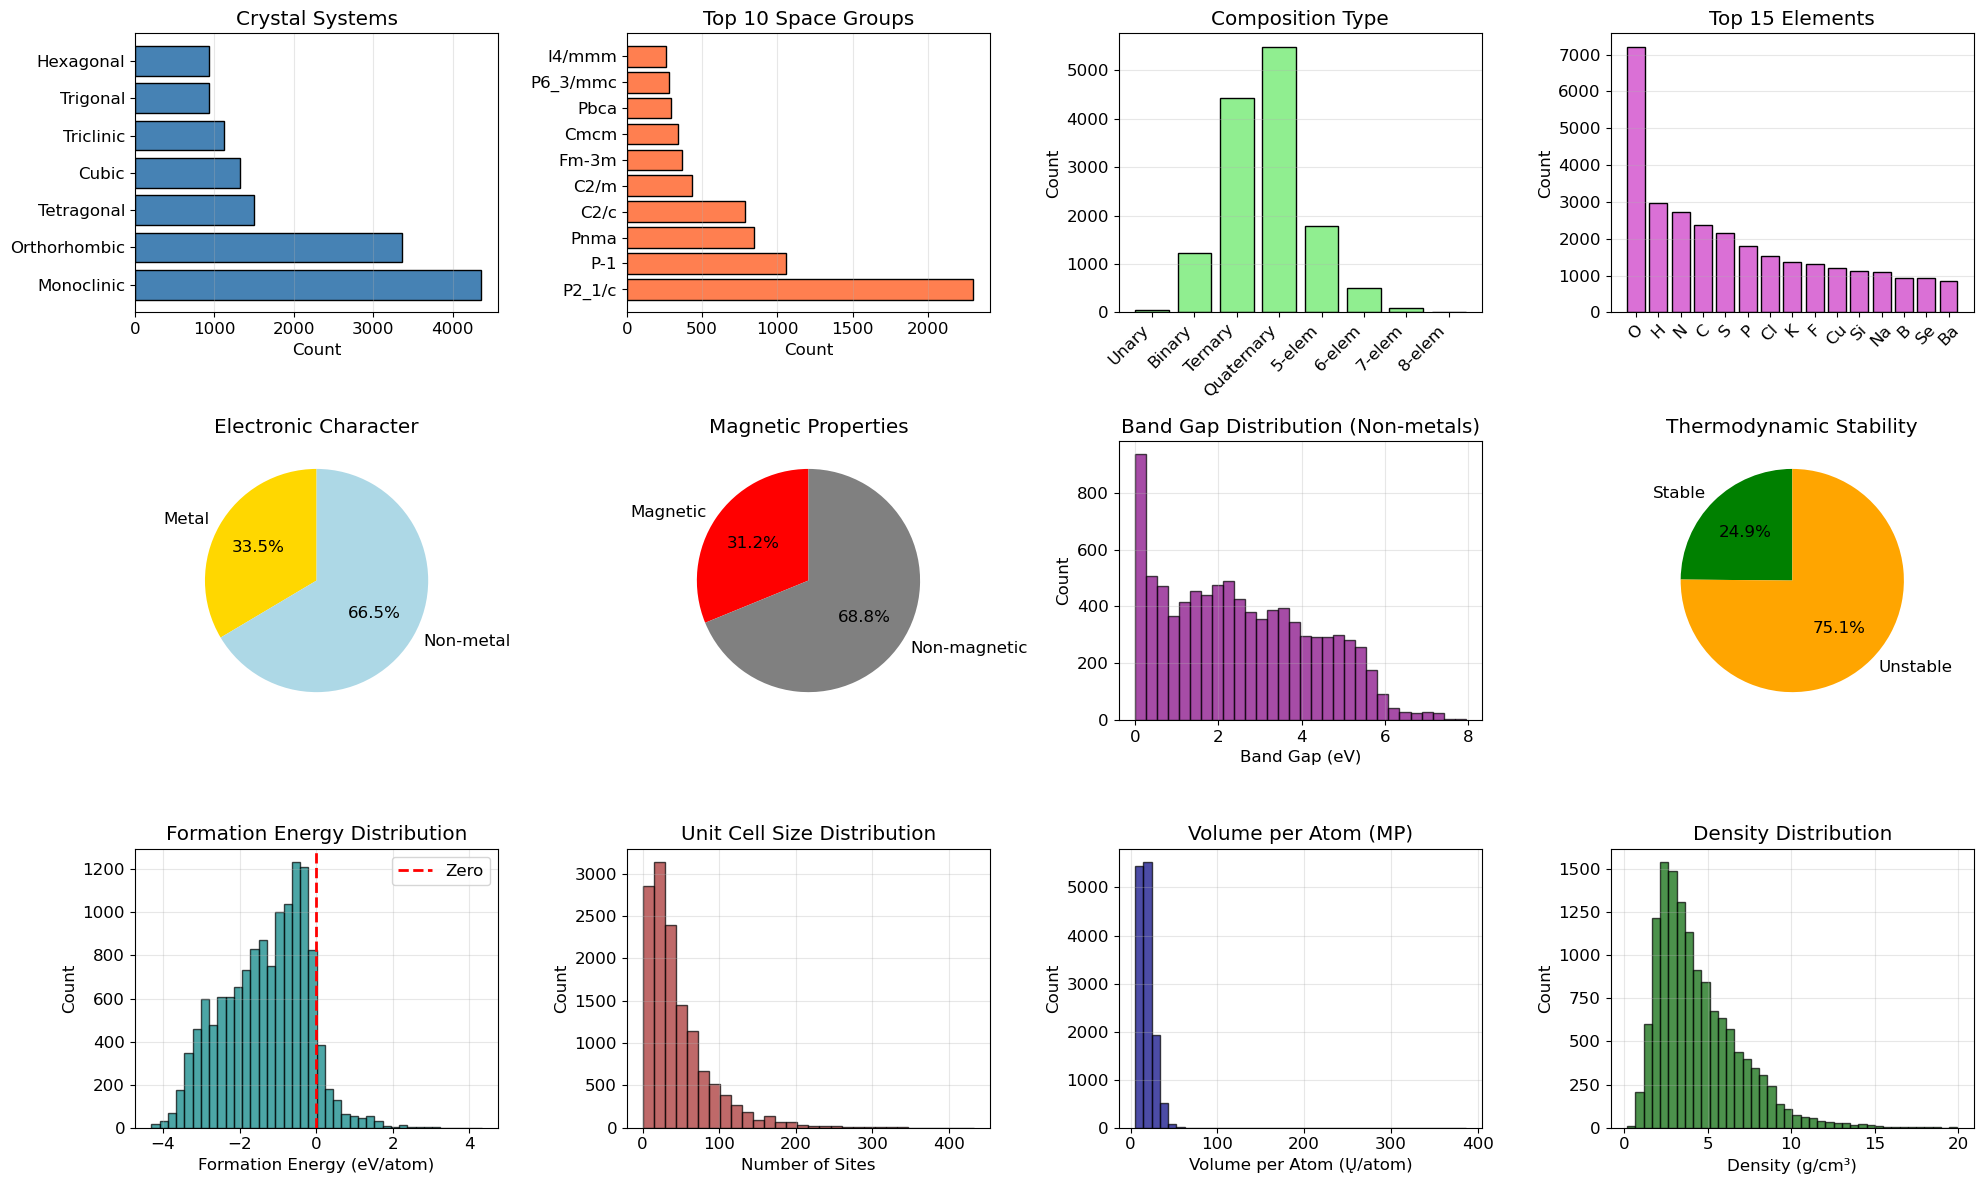

Total materials analyzed: 13528
Figures saved to 'material_database_statistics.png'


In [13]:
# Create figure with multiple subplots
fig = plt.figure(figsize=(20, 12))

# 1. Crystal Systems
ax1 = plt.subplot(3, 4, 1)
crystal_counter = Counter(stats['crystal_systems'])
systems, counts = zip(*crystal_counter.most_common())
ax1.barh(systems, counts, color='steelblue', edgecolor='black')
ax1.set_xlabel('Count')
ax1.set_title('Crystal Systems')
ax1.grid(alpha=0.3, axis='x')

# 2. Top 10 Space Groups
ax2 = plt.subplot(3, 4, 2)
sg_counter = Counter(stats['space_groups'])
sgs, sg_counts = zip(*sg_counter.most_common(10))
ax2.barh(range(len(sgs)), sg_counts, color='coral', edgecolor='black')
ax2.set_yticks(range(len(sgs)))
ax2.set_yticklabels(sgs)
ax2.set_xlabel('Count')
ax2.set_title('Top 10 Space Groups')
ax2.grid(alpha=0.3, axis='x')

# 3. Composition (nelements)
ax3 = plt.subplot(3, 4, 3)
nelements_counter = Counter(stats['nelements'])
nelements_sorted = sorted(nelements_counter.items())
n_elem, n_counts = zip(*nelements_sorted)
labels = ['Unary', 'Binary', 'Ternary', 'Quaternary'] + [f'{n}-elem' for n in range(5, max(n_elem)+1)]
ax3.bar(range(len(n_elem)), n_counts, color='lightgreen', edgecolor='black')
ax3.set_xticks(range(len(n_elem)))
ax3.set_xticklabels([labels[i] for i in range(len(n_elem))], rotation=45, ha='right')
ax3.set_ylabel('Count')
ax3.set_title('Composition Type')
ax3.grid(alpha=0.3, axis='y')


# 4. Top 15 Elements
ax4 = plt.subplot(3, 4, 4)
element_counter = Counter(stats['elements_list'])
elements, elem_counts = zip(*element_counter.most_common(15))
ax4.bar(elements, elem_counts, color='orchid', edgecolor='black')
ax4.set_ylabel('Count')
ax4.set_title('Top 15 Elements')
ax4.grid(alpha=0.3, axis='y')
ax4.tick_params(axis='x', rotation=45)


# 5. Metal vs Non-metal
ax5 = plt.subplot(3, 4, 5)
metals = sum(stats['is_metal'])
non_metals = len(data) - metals
ax5.pie([metals, non_metals], labels=['Metal', 'Non-metal'], autopct='%1.1f%%',
        colors=['gold', 'lightblue'], startangle=90)
ax5.set_title('Electronic Character')


# 6. Magnetic vs Non-magnetic
ax6 = plt.subplot(3, 4, 6)
magnetic = sum(stats['is_magnetic'])
non_magnetic = len(data) - magnetic
ax6.pie([magnetic, non_magnetic], labels=['Magnetic', 'Non-magnetic'], autopct='%1.1f%%',
        colors=['red', 'gray'], startangle=90)
ax6.set_title('Magnetic Properties')

# 7. Band gap distribution (non-metals only)
ax7 = plt.subplot(3, 4, 7)
non_metal_gaps = [bg for bg, metal in zip(stats['band_gap'], stats['is_metal']) 
                  if not metal and bg is not None and bg > 0]
if non_metal_gaps:
    ax7.hist(non_metal_gaps, bins=30, color='purple', edgecolor='black', alpha=0.7)
    ax7.set_xlabel('Band Gap (eV)')
    ax7.set_ylabel('Count')
    ax7.set_title('Band Gap Distribution (Non-metals)')
    ax7.grid(alpha=0.3)

# 8. Stable vs Unstable
ax8 = plt.subplot(3, 4, 8)
stable = sum(stats['is_stable'])
unstable = len(data) - stable
ax8.pie([stable, unstable], labels=['Stable', 'Unstable'], autopct='%1.1f%%',
        colors=['green', 'orange'], startangle=90)
ax8.set_title('Thermodynamic Stability')

# 9. Formation energy distribution
ax9 = plt.subplot(3, 4, 9)
ax9.hist(stats['formation_energy'], bins=40, color='teal', edgecolor='black', alpha=0.7)
ax9.axvline(0, color='r', linestyle='--', linewidth=2, label='Zero')
ax9.set_xlabel('Formation Energy (eV/atom)')
ax9.set_ylabel('Count')
ax9.set_title('Formation Energy Distribution')
ax9.legend()
ax9.grid(alpha=0.3)

# 10. Number of sites distribution
ax10 = plt.subplot(3, 4, 10)
ax10.hist(stats['nsites'], bins=30, color='brown', edgecolor='black', alpha=0.7)
ax10.set_xlabel('Number of Sites')
ax10.set_ylabel('Count')
ax10.set_title('Unit Cell Size Distribution')
ax10.grid(alpha=0.3)

# 11. Volume per atom (MP)
ax11 = plt.subplot(3, 4, 11)
ax11.hist(stats['volume_per_atom_mp'], bins=40, color='navy', edgecolor='black', alpha=0.7)
ax11.set_xlabel('Volume per Atom (Ų/atom)')
ax11.set_ylabel('Count')
ax11.set_title('Volume per Atom (MP)')
ax11.grid(alpha=0.3)

# 12. Density distribution
ax12 = plt.subplot(3, 4, 12)
ax12.hist(stats['density'], bins=40, color='darkgreen', edgecolor='black', alpha=0.7)
ax12.set_xlabel('Density (g/cm³)')
ax12.set_ylabel('Count')
ax12.set_title('Density Distribution')
ax12.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('material_database_statistics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Total materials analyzed: {len(data)}")
print(f"Figures saved to 'material_database_statistics.png'")